In [1]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set(context='talk', style='whitegrid', color_codes=True)

In [2]:
mpl.rcParams['figure.figsize'] = (10,6)
con = sqlite3.connect('kaepora_v1.db')

In [3]:
query = "SELECT * FROM Events;"
table = pd.read_sql(query, con)

col_slc = ['SN', 'RA', 'DEC', 'M_b_cfa', 'M_b_cfa_err', 'Bmag_salt', 'e_Bmag_salt', 'Bmag_salt2', 'e_Bmag_salt2', 'V_at_max', 'V_err']
table = table[col_slc]

In [4]:
table.columns

Index(['SN', 'RA', 'DEC', 'M_b_cfa', 'M_b_cfa_err', 'Bmag_salt', 'e_Bmag_salt',
       'Bmag_salt2', 'e_Bmag_salt2', 'V_at_max', 'V_err'],
      dtype='object')

In [5]:
colname = ['SN', 'RA', 'Dec', 'Bmag_CFA', 'Bmag_CFA_err', 'Bmag_SALT', 'Bmag_SALT_err', 'Bmag_SALT2', 'Bmag_SALT2_err', 'v', 'v_err']
table = table.rename({old: new for old, new in zip(col_slc, colname)}, axis=1)
table.head()

,SN,RA,Dec,Bmag_CFA,Bmag_CFA_err,Bmag_SALT,Bmag_SALT_err,Bmag_SALT2,Bmag_SALT2_err,v,v_err
0,ls05d3la,14:21:25.418,+52:21:28.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ls05d3lb,14:17:31.758,+53:10:04.54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ls05d3lc,14:22:22.920,+52:28:43.91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ls05d3lr,14:22:12.142,+53:11:03.39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2006te,08:11:42.99,+41:33:16.8,-19.42,0.08,16.502,0.138,16.576,0.012,NaN,NaN


In [6]:
table.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1704 entries, 0 to 1703
Data columns (total 11 columns):
SN                1704 non-null object
RA                1116 non-null object
Dec               1116 non-null object
Bmag_CFA          120 non-null float64
Bmag_CFA_err      120 non-null float64
Bmag_SALT         397 non-null float64
Bmag_SALT_err     397 non-null float64
Bmag_SALT2        351 non-null float64
Bmag_SALT2_err    351 non-null float64
v                 311 non-null float64
v_err             302 non-null float64
dtypes: float64(8), object(3)
memory usage: 146.5+ KB


In [30]:
len(set(table['SN'].tolist()).intersection(set(sn_data.index.tolist())))

88

In [38]:
len(set(sn_data.index.tolist()))

153

In [37]:
len(set(table['SN'].tolist()))

311

In [33]:
len(table), len(sn_data)

(311, 153)

In [7]:
table = table.loc[table['v'].notna()]

Text(0.5, 1.0, 'Wang, X. et al. 2013')

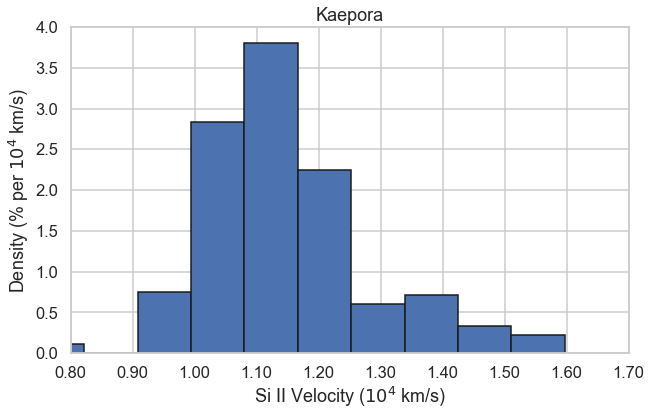

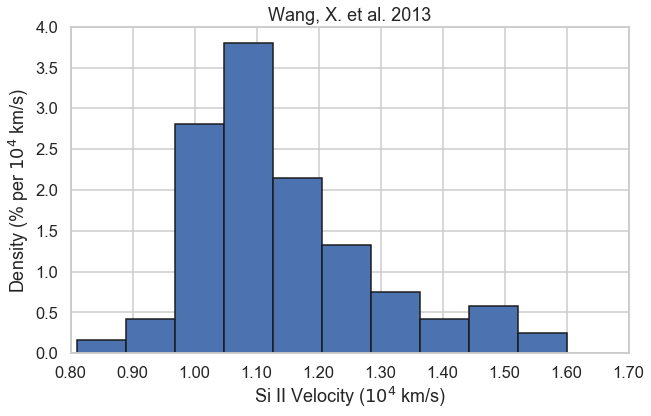

In [43]:
x = -table['v'] / 10.
# bins = np.arange(0.8, 1.75, 0.05)
plt.hist(x, density=True, fill=True, edgecolor='k', joinstyle='miter', label='Observed')

plt.xticks(bins[::2], [f'{tick:.2f}' for tick in bins[::2]])
plt.xlim(bins.min(), bins.max())
plt.xlabel('Si II Velocity ($10^4$ km/s)')
plt.ylabel('Density (% per $10^4$ km/s)')
plt.title('Kaepora')

plt.figure()

x = sn_data['v_siII']
plt.hist(x, density=True, fill=True, edgecolor='k', joinstyle='miter', label='Observed')

plt.xticks(bins[::2], [f'{tick:.2f}' for tick in bins[::2]])
plt.xlim(bins.min(), bins.max())
plt.xlabel('Si II Velocity ($10^4$ km/s)')
plt.ylabel('Density (% per $10^4$ km/s)')
plt.title('Wang, X. et al. 2013')

# plt.tight_layout()

In [42]:
def import_sn_data(fpath='sn_data.txt'):
    df = pd.read_csv(fpath, sep='\s+', index_col=0, na_values=['...', 'NaN'])
    df = clean_sn_data(df)
    return df
    
    
def clean_sn_data(df):
    df = (df
          .iloc[:,[0,9]]
          .loc[~df['v_siII'].isnull(), :]
          .loc[(df['v_siII'] > 0.7) & (df['v_siII'] < 1.8)]
         )
    return df

sn_data = import_sn_data()
display(sn_data.head())
display(sn_data.info(verbose=True))
display(sn_data.describe())

,SN_Host,v_siII
SN,,
1998de,NGC252,1.13
1998dk,UGC139,1.27
1998ef,UGC646,1.33
1998es,NGC632,1.18
1999aa,NGC2595,1.04


<class 'pandas.core.frame.DataFrame'>
Index: 153 entries, 1998de to 2008hv
Data columns (total 2 columns):
SN_Host    153 non-null object
v_siII     153 non-null float64
dtypes: float64(1), object(1)
memory usage: 3.6+ KB


None

,v_siII
count,153.000000
mean,1.141438
std,0.150028
min,0.810000
25%,1.040000
50%,1.100000
75%,1.210000
max,1.600000


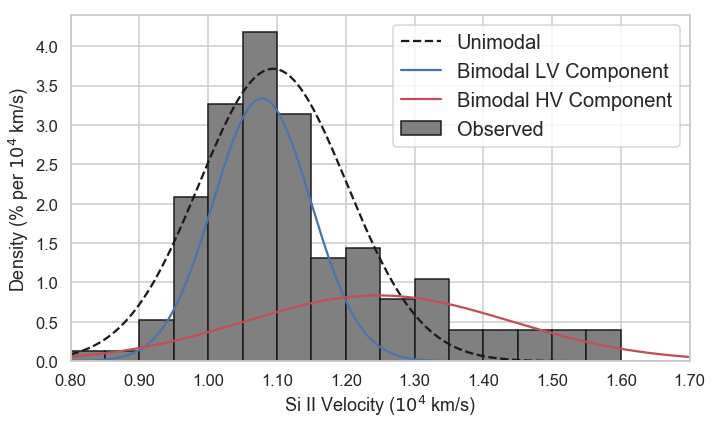

In [15]:
from scipy.optimize import curve_fit
from mcmc import gaussian, bimodal_gaussian

x = sn_data['v_siII']
bins = np.arange(0.8, 1.75, 0.05)
plt.hist(x, density=True, bins=bins, color='gray', fill=True, edgecolor='k', joinstyle='miter', label='Observed')

# Unimodal Gaussian
xrange = np.linspace(bins.min(), bins.max(), 200)
ydata, xdata = np.histogram(x, bins=np.arange(0.8, 1.75, 0.1), density=True)
xdata = (xdata[:-1] + xdata[1:]) / 2
opt, cov = curve_fit(gaussian, xdata, ydata, p0=[np.mean(x), np.std(x)])
plt.plot(xrange, gaussian(xrange, *opt), '--', color='k', label='Unimodal')

# Bimodal Gaussian
opt, cov = curve_fit(bimodal_gaussian, xdata, ydata, p0=[1.1, 1, 1.5, 1, 0.5])
# plt.plot(xrange, bimodal_gaussian(xrange, *opt), color='gray', label='Bimodal')
plt.plot(xrange, opt[4]*gaussian(xrange, *opt[0:2]), 'b', label='Bimodal LV Component')
plt.plot(xrange, (1-opt[4])*gaussian(xrange, *opt[2:4]), 'r', label='Bimodal HV Component')

# Plot config
plt.xticks(bins[::2], [f'{tick:.2f}' for tick in bins[::2]])
plt.xlim(bins.min(), bins.max())
plt.legend(fontsize=20)
plt.xlabel('Si II Velocity ($10^4$ km/s)')
plt.ylabel('Density (% per $10^4$ km/s)')

# Save results
plt.tight_layout()
plt.savefig('velocity_dist.png', orientation='landscape', format='png', dpi=600)
np.savetxt('bimodal_params.txt', opt)